In [1]:
%load_ext autoreload
%autoreload 2
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../../timeseries/')
sys.path.append('../../src/')
import factors
import observation_models
import state_models
from ssm_em import StateSpaceEM
import pandas
import os

In [2]:
de_energy_df = pandas.read_csv('../../data/opsd/time_series_60min_singleindex_filtered.csv')
de_energy_df['utc_timestamp'] = pandas.to_datetime(de_energy_df['utc_timestamp'].astype(str).apply(lambda x: x[:10]))
de_energy_df = de_energy_df.groupby('utc_timestamp').mean()
de_weather_df = pandas.read_csv('../../data/opsd/weather_data_filtered.csv')
de_weather_df['utc_timestamp'] = pandas.to_datetime(de_weather_df['utc_timestamp'].astype(str).apply(lambda x: x[:10]))
de_weather_df = de_weather_df.groupby('utc_timestamp').mean()

In [3]:
full_df = pandas.concat([de_energy_df[['DE_solar_generation_actual', 'DE_wind_generation_actual']], de_weather_df[['DE_temperature', 'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal']]], axis=1)

In [4]:
#full_df = full_df.iloc[numpy.where(numpy.logical_and(full_df.index.weekday != 5, full_df.index.weekday != 6))[0]]

In [5]:
from scipy.stats import zscore
full_df = full_df.fillna(method='backfill')
X = zscore(full_df, nan_policy='omit')[1:-1]
X_train = X[:int(365 * 3)]
X_test = X[int(365 * 3):]

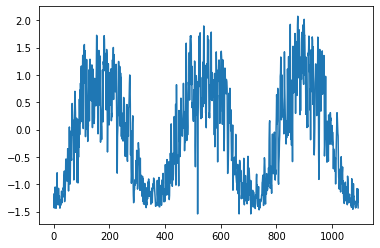

In [6]:
pyplot.plot(X_train[:,0])

In [7]:
X.shape

(1826, 5)

In [40]:
Dz = 4
Dx = X.shape[1]
sm = state_models.LinearStateModel(Dz)
om = observation_models.LinearObservationModel(Dx, Dz, noise_x=1.)
om.pca_init(X_train)
ssm_em_lin = StateSpaceEM(X_train, observation_model=om, state_model=sm)
ssm_em_lin.run()

Iteration 2 - llk=-4842.2
Iteration 4 - llk=-3446.4
Iteration 6 - llk=-2806.9
Iteration 8 - llk=-2479.6
Iteration 10 - llk=-2338.4
Iteration 12 - llk=-2234.9
Iteration 14 - llk=-2144.8
Iteration 16 - llk=-2069.9
Iteration 18 - llk=-2005.8
Iteration 20 - llk=-1951.8
Iteration 22 - llk=-1910.0
Iteration 24 - llk=-1879.7
Iteration 26 - llk=-1858.6
Iteration 28 - llk=-1843.8
Iteration 30 - llk=-1833.0
Iteration 32 - llk=-1824.8
Iteration 34 - llk=-1818.4
Iteration 36 - llk=-1813.1
Iteration 38 - llk=-1808.8


KeyboardInterrupt: 

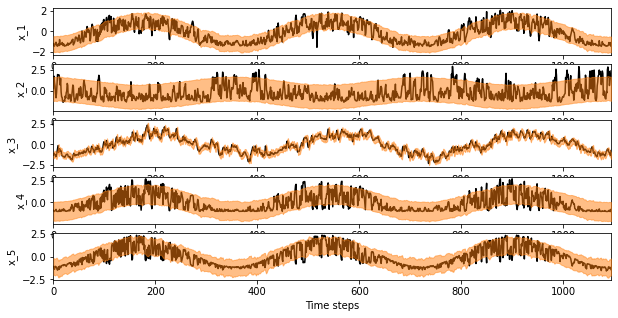

In [35]:
p_x = ssm_em_lin.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(5):
    pyplot.subplot(5,1,ix+1)
    x_min = p_x.mu[:4000,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:4000,ix,ix])
    x_max = p_x.mu[:4000,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:4000,ix,ix])
    pyplot.plot(X_train[:4000,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X_train.shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [37]:
Dz = 4
Dx = X.shape[1]
Du = 4
sm = state_models.LinearStateModel(Dz)
# Here we change the observation model.
om = observation_models.HCCovObservationModel(Dx, Dz, Du)
om.pca_init(X_train)
ssm_em = StateSpaceEM(X_train, observation_model=om, state_model=sm)
ssm_em.run()

Iteration 2 - llk=-3813.6
Iteration 4 - llk=-2607.0
Iteration 6 - llk=-1994.1
Iteration 8 - llk=-1705.4
Iteration 10 - llk=-1575.4
Iteration 12 - llk=-1521.5
Iteration 14 - llk=-1490.6


KeyboardInterrupt: 

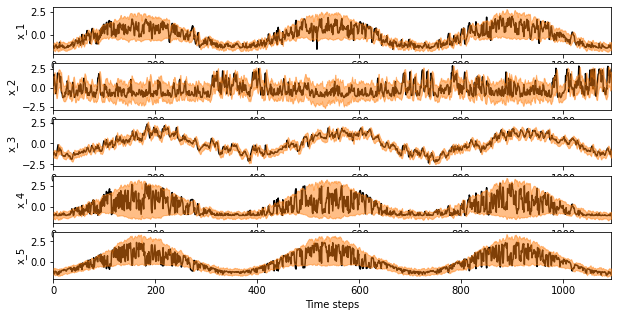

In [38]:
p_x = ssm_em.compute_data_density()
pyplot.figure(figsize=(10,5))
for ix in range(5):
    pyplot.subplot(5,1,ix+1)
    ix += 0
    x_min = p_x.mu[:,ix] - 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    x_max = p_x.mu[:,ix] + 1.68 * numpy.sqrt(p_x.Sigma[:,ix,ix])
    pyplot.plot(X_train[:,ix],'k')
    pyplot.fill_between(range(x_min.shape[0]), x_min, x_max, color='C1', alpha=.5, zorder=9)
    pyplot.ylabel('x_%d' %(ix+1))
    pyplot.xlim([0,X_train[:].shape[0]])
pyplot.xlabel('Time steps')
pyplot.show()

In [39]:
ssm_em.compute_predictive_log_likelihood(X_test)

-1341.473482062757

In [41]:
ssm_em_lin.compute_predictive_log_likelihood(X_test)

-1569.6994214055117

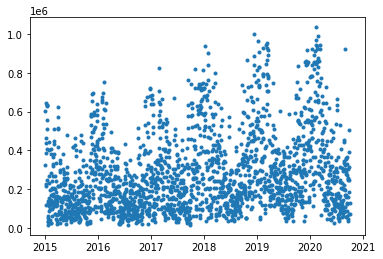

In [103]:
pyplot.plot(de_energy_df['DE_wind_generation_actual'][1:], '.')

In [87]:
de_energy_df[de_energy_df['utc_timestamp'] == day].sum(axis=0)

<ipython-input-87-6ead1349db0b>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  de_energy_df[de_energy_df['utc_timestamp'] == day].sum(axis=0)


cet_cest_timestamp                    2020-09-29T02:00:00+02002020-09-29T03:00:00+02...
DE_load_actual_entsoe_transparency                                            1388260.0
DE_solar_generation_actual                                                      88967.0
DE_wind_generation_actual                                                       73214.0
dtype: object